In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import pickle

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import os.path as osp 
import os
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, OneHotEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis #LDA
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel #para seleccionar los coeficientes de lasso
from sklearn.metrics import roc_auc_score, f1_score
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
set_config(display="diagram")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/sample_submission.csv
/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/Diccionario.xlsx
/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/df_test.parquet
/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/df_train.parquet


In [2]:
DATA_DIR = "/kaggle/input/fa-ii-2024-ii-flujos-de-modelos-tradicionales/"
df = pd.read_parquet(osp.join(DATA_DIR, "df_train.parquet"))
print(df.shape)
df.head()

(23494, 46)


,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Target,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
16484,12.0,3.0,3.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,58373.057143,-110021.200000,1.885690e+05
11528,6.0,1.0,1.0,2,0.5,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,19618.942857,-36176.133333,9.747050e+04
26630,1.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,1,398534.000000,-626628.000000,2.304723e+06
12586,6.0,0.0,2.0,2,0.0,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,1292.600000,13410.733333,5.380450e+04
11225,3.0,0.0,2.0,1,1.0,NaN,0.0,NaN,NaN,1.0,...,2,2,2,2,2,2,0,13728.714286,-27375.666667,4.134967e+04


In [3]:
df1 = pd.read_parquet(osp.join(DATA_DIR, "df_test.parquet"))
print(df1.shape)
df1.head()

(10069, 45)


,MEDICAMENTOS,MEDICINA ESPECIALIZADA,MEDICINA GENERAL,Cant_gr_flia,Cant_riesgos_flia_mean,min_Tiempo_CP_Fliar,Cant_Fliar_CP,psa_max_gr_flia,psa_min_gr_flia,Cant_Fliar_riesgos,...,CORONARIOS,CORONARIOS_FAMILIAR,CEREBRAL,CEREBRAL_FAMILIAR,ENFERMEDAD_RENAL,ENFERMEDAD_RENAL_FAMILIAR,OTROS_ANTECEDENTES_VASCULARES,Pendiente,Intercepto,Promedio_costo
ID,,,,,,,,,,,,,,,,,,,,,
12596,2.0,4.0,2.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,5.421180e+06,-1.256617e+07,9.611937e+06
29326,4.0,0.0,1.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,-9.504343e+03,5.997787e+04,8.013800e+04
24338,0.0,0.0,1.0,2,0.000000,NaN,0.0,NaN,NaN,0.0,...,0,0,0,0,0,0,0,2.477143e+03,-5.780000e+03,1.734000e+04
11167,1.0,0.0,0.0,1,0.000000,NaN,0.0,NaN,NaN,0.0,...,1,0,1,0,1,0,0,3.597143e+03,-8.393333e+03,2.518000e+04
22074,36.0,0.0,1.0,3,0.666667,NaN,0.0,NaN,NaN,1.0,...,0,0,0,0,0,0,0,-9.042514e+03,6.309881e+05,5.993393e+05


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10069 entries, 12596 to 22281
Data columns (total 45 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MEDICAMENTOS                   10069 non-null  float64
 1   MEDICINA ESPECIALIZADA         10069 non-null  float64
 2   MEDICINA GENERAL               10069 non-null  float64
 3   Cant_gr_flia                   10069 non-null  int64  
 4   Cant_riesgos_flia_mean         10069 non-null  float64
 5   min_Tiempo_CP_Fliar            2 non-null      float64
 6   Cant_Fliar_CP                  10069 non-null  float64
 7   psa_max_gr_flia                76 non-null     float64
 8   psa_min_gr_flia                76 non-null     float64
 9   Cant_Fliar_riesgos             10069 non-null  float64
 10  cantidad_serv_flia             10069 non-null  float64
 11  Pendiente_flia                 10069 non-null  float64
 12  Intercepto_flia                10069 non-null  

In [5]:
X, y = df.drop(columns="Target"), df["Target"]
y.value_counts(True) * 100


Target
0    71.537414
1    28.462586
Name: proportion, dtype: float64

In [6]:
porcetaje_de_nulidad = (
    X.isnull()
    .apply(lambda s: s.value_counts(True)).T
) 

porcetaje_de_nulidad.columns = ['not_null', 'null']
variables_muy_nulas = porcetaje_de_nulidad.query('null > 0.7').index

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [8]:
var_numericas = X_train.select_dtypes('number').columns
var_categoricas = X_train.select_dtypes('object').columns

In [9]:
print(y_train.value_counts(True)*100)
print(y_test.value_counts(True)*100)

Target
0    71.590966
1    28.409034
Name: proportion, dtype: float64
Target
0    71.234043
1    28.765957
Name: proportion, dtype: float64


# Data Processing

Ejemplo sobre como usar Pipelines: https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html

https://towardsdatascience.com/creating-custom-transformers-for-sklearn-pipelines-d3d51852ecc1

In [10]:
# Define el Custom Transformer
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, multiply_by=1):  # Define parámetros si es necesario
        self.multiply_by = multiply_by

    def fit(self, X, y=None):
        # En el fit normalmente se calculan parámetros, pero aquí no se necesita
        return self

    def transform(self, X):
        # Aplica la transformación a los datos
        return X * self.multiply_by

In [11]:
# Ejemplo de pipeline con el transformador personalizado
pipeline_sam = Pipeline([
    ('scaler', StandardScaler()),  # Ejemplo de transformador estándar
    ('custom', CustomTransformer(multiply_by=3))  # Nuestro transformador personalizado
])

In [12]:
# Datos de ejemplo
X_sam = np.array([[1, 2], [3, 4], [5, 6]])

In [13]:
X_sam

array([[1, 2],
       [3, 4],
       [5, 6]])

In [14]:
# Aplicar el pipeline
transformed_X = pipeline_sam.fit_transform(X_sam)
print(transformed_X)

[[-3.67423461 -3.67423461]
 [ 0.          0.        ]
 [ 3.67423461  3.67423461]]


In [15]:
class LDATransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        self.clf = LinearDiscriminantAnalysis()
        self.clf.fit(X,y) 
        return self

    def transform(self, X, y=None):
      # Perform arbitary transformation
        X_transformed = X.copy()
        lda = pd.DataFrame(self.clf.transform(X_transformed)).rename(columns={0:'LDA'})
        X_transformed=pd.DataFrame(X_transformed)
        X_transformed = pd.concat([X_transformed,lda],axis=1)
        return X_transformed

In [16]:
Imputer = SimpleImputer(strategy="median")
Scaler = StandardScaler()
LDA = LinearDiscriminantAnalysis()

In [17]:
X_num = X[var_numericas].copy()

In [18]:
Imputer.fit(X_num)
X_num_proces = Imputer.transform(X_num)

In [19]:
Scaler.fit(X_num_proces)
X_num_proces = Scaler.transform(X_num_proces)

In [20]:
LDA.fit(X_num_proces,y)

LinearDiscriminantAnalysis()

In [21]:
X_num_proces = LDA.transform(X_num_proces)

In [22]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("LDA_feature",LDATransformer())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop="if_binary")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, var_numericas),
        ("cat", categorical_transformer, var_categoricas),
    ]
)

In [23]:
preprocessor.fit(X,y)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('LDA_feature',
                                                  LDATransformer())]),
                                 Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr_flia', 'psa_min_gr_flia',
       'Cant_Fli...
                                 Index(['ESTADO_CIVI', 'PROGRAMA', 'estrato', 'IMC', 'AGRUPACION_SISTOLICA',
       'AGRUPACION_DIASTOLICA', 'parentesco', 'CANCER_MAMA_FAMILIAR',
       'CANCER_OTRO_SITIO', 'CANCER_OTRO_SITIO_FAMILIAR', 'HIPERTENSION',
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object'))])

In [24]:
X_a=preprocessor.transform(X)

In [25]:
def add_model(data_pipeline, model) -> Pipeline:
    whole_pipeline = Pipeline([
        ("data_pipeline", data_pipeline),
        ("model", model)
    ])
    return whole_pipeline

# Bayesian optimization

In [26]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import collections
%matplotlib inline

def live_plot(data_dict, figsize=(7,5), title='', win_size: int = 100):
    """
    Función para mostrar en tiempo real el progreso de la optmización bayesiana.
    """
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        if len(data) > win_size:
            data = data[-win_size:]
            iterations = np.arange(len(data))[-win_size:] 
        else:
            iterations = np.arange(len(data))
        plt.plot(iterations, data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Iteration')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show();

In [27]:
data = collections.defaultdict(list)

def train_and_evaluate_SVM(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,

    #Modelo SVC
    SVC_C,
    SVC_gamma,
    kernel_SVC='linear'

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    
    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls()),
               #("LDA_feature",LDATransformer()) 
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
        
    ])
           
    #Model SVM
    model = SVC(C=SVC_C, gamma=SVC_gamma, kernel=kernel_SVC, probability=True)
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [0.5,0.6,0.65] 
    val_fold_metrics = [0.4, 0.45,0.47]

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate_SVM(**kwargs)
    return result


In [28]:
pbounds_SVM = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    SVC_C=(0.001, 0.1),
    SVC_gamma=(0,2)
   
)

optimizer_SVM = BayesianOptimization(
    f=target_func,
    pbounds=pbounds_SVM,
    random_state=963,
    verbose=2,
)




In [29]:
data_plot = collections.defaultdict(list)

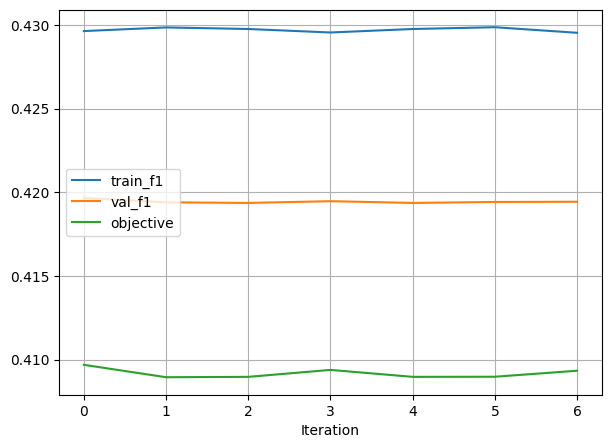

| 7         | 0.4093    | 0.05602   | 0.1917    | 0.6955    | 0.8301    | 3.455     | 0.1659    |


In [30]:
optimizer_SVM.maximize(
    init_points=2,
    n_iter=5,
)

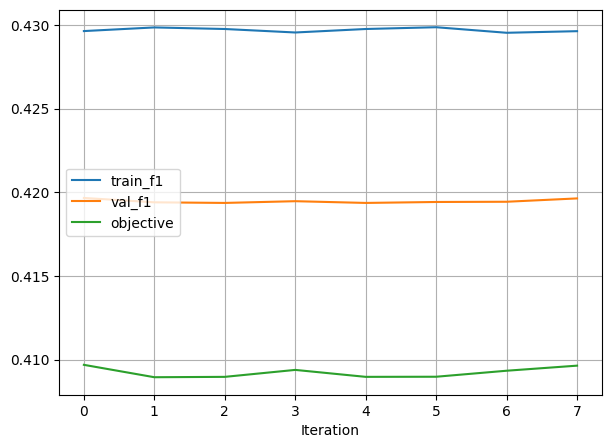

In [31]:
best_model_SVM, best_resultSVM = train_and_evaluate_SVM(**optimizer_SVM.max["params"])

In [32]:
test_preds_SVM = best_model_SVM.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, test_preds_SVM)

0.5418372180158781

In [33]:
data = collections.defaultdict(list)

def train_and_evaluate_NN(
    # Data 
    scaler_choice,
    imputer_strategy,
    knn_imputer,
    knn_imputer_k,
    #pca_components,
    # Model
    model_hidden_layer_size_exp,
    model_lr_init,
    model_alpha,
    model_batch_size,
    model_max_iter,
    #model_solver,
    verbose=0,
    show_live_plot=True

) -> float:
    scaler_cls = StandardScaler if scaler_choice > 0.5 else MinMaxScaler
    imputer_strategy = "mean" if imputer_strategy > 0.5 else "median"
    if knn_imputer > 0.5:
        imputer = KNNImputer(n_neighbors=int(knn_imputer_k))
    else:
        imputer = SimpleImputer(strategy=imputer_strategy)
    
    numeric_transformer = Pipeline(
        steps=[("imputer", imputer), 
               ("scaler", scaler_cls()),
               #("LDA_feature",LDATransformer()) 
              ]
    )
    
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, var_numericas),
            ("cat", categorical_transformer, var_categoricas),
        ]
    )
    
    data_pipeline = Pipeline(steps=[
        ("data_processor", preprocessor),
        
    ])
           
    ## Model configuration
    
    max_exponent = int(model_hidden_layer_size_exp)
    if max_exponent<2:
        max_exponent=2
        
    model_kwargs = dict(
        hidden_layer_sizes = [2**(n) for n in reversed(range(2, max_exponent+1))], ### Arquitectura
        #solver="adam" if model_solver > 0.5 else "sgd",
        batch_size=2**int(model_batch_size), ## Back Propagation
        learning_rate_init=model_lr_init,## Back Propagation
        alpha=model_alpha,## Back Propagation
        max_iter=int(model_max_iter),
        early_stopping=True,
        random_state=42,
    )
    
    if verbose:
        print("MLP Classifier params: ")
        pprint(model_kwargs)
    
    model = MLPClassifier(**model_kwargs)
    
    pipeline = add_model(data_pipeline, model)
    show_live_plot=True

    ## Training protocol
    
    kf = KFold(n_splits=3, random_state=963, shuffle=True)
    
    train_fold_metrics = [] 
    val_fold_metrics = []

    # K-Fold cross val
    for i, (train_index, test_index) in enumerate(kf.split(X_train)):
        #print(f"Fold number: {i+1}")
        kX_train, kX_val = X_train.iloc[train_index], X_train.iloc[test_index]
        ky_train, ky_val = y_train.iloc[train_index], y_train.iloc[test_index]
        #print(f"Training with {kX_train.shape}")
        #print(f"Validating with {kX_val.shape}")
        pipeline.fit(kX_train, ky_train)
        
        val_preds = pipeline.predict_proba(kX_val)[:, 1]
               
        train_preds = pipeline.predict_proba(kX_train)[:, 1]
        
        ths = np.linspace(0, 1, 1000)
        best_th = ths[np.argmax([f1_score(ky_val, val_preds>th) for th in ths])]
        best_th
        
        val_f1 = f1_score(ky_val, val_preds>best_th)
        train_f1 = f1_score(ky_train, train_preds>best_th)
        
        train_fold_metrics.append(train_f1)
        val_fold_metrics.append(val_f1)            
       
    f1_train = np.array(train_fold_metrics)
    f1_val = np.array(val_fold_metrics)
    
    adj_val_f1 = ( f1_val.mean() -  f1_val.std())
    adj_train_f1 = ( f1_train.mean() -  f1_train.std())
    objective = adj_val_f1 - abs(adj_val_f1 - adj_train_f1)
    
    print(f"Validation F1 adjusted score: {adj_val_f1}")
    print(f"Train F1 adjusted score: {adj_train_f1}")
    print()
    
    if show_live_plot:
        data['train_f1'].append(adj_train_f1)
        data['val_f1'].append(adj_val_f1)
        data["objective"].append(objective)
        live_plot(data)
    
    return pipeline, objective

def target_func(**kwargs):
    model, result = train_and_evaluate_NN(**kwargs)
    return result

In [34]:
pbounds_NN = dict(
    # Data
    scaler_choice=(0, 1),
    imputer_strategy=(0, 1),
    knn_imputer=(0,1),
    knn_imputer_k=(3, 10),
    # Model
    #model_solver=(0, 1),
    model_hidden_layer_size_exp=(2, 4),
    model_lr_init=(0.005, 0.5),
    model_alpha=(0.001, 1),
    model_batch_size=(3, 7), # from 2**6=64 to 2**12=4096
    model_max_iter=(50, 50)
   
)


In [35]:
data_plot = collections.defaultdict(list)

In [36]:
optimizer = BayesianOptimization(
    f=target_func,
    pbounds=pbounds_NN,
    random_state=963,
    verbose=2,
)

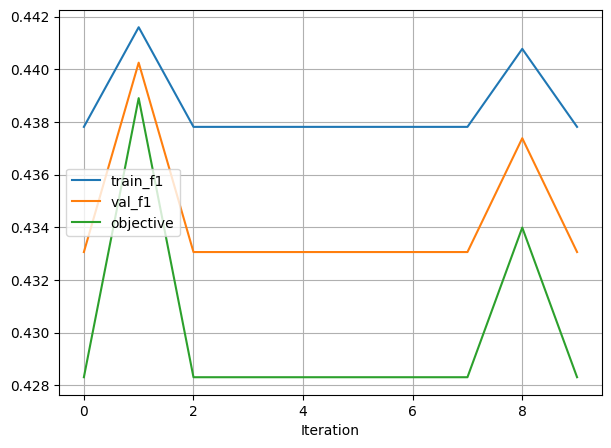

| 10        | 0.4283    | 0.07912   | 0.6014    | 5.9       | 0.4963    | 5.905     | 2.422     | 0.2698    | 50.0      | 0.8471    |


In [37]:
#logger = JSONLogger(path="./logs.json")
#optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)

optimizer.maximize(
    n_iter=5,
)

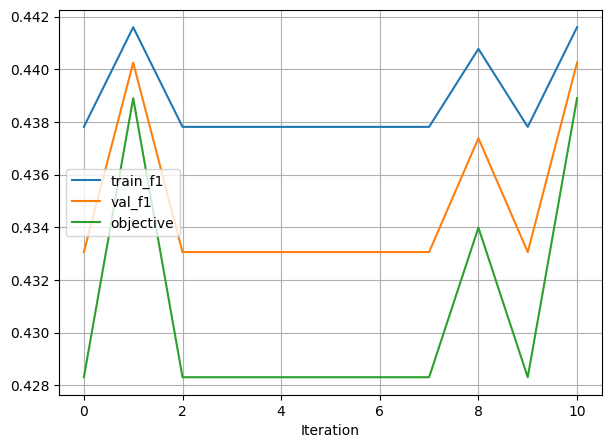

In [38]:
best_model_NN, best_result_NN = train_and_evaluate_NN(**optimizer.max["params"])

In [39]:
test_preds_NN = best_model_NN.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, test_preds_NN)

0.5587328967532993

In [40]:
best_model = best_model_NN

In [41]:
best_model.fit(X, y)

Pipeline(steps=[('data_pipeline',
                 Pipeline(steps=[('data_processor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    KNNImputer(n_neighbors=8)),
                                                                                   ('scaler',
                                                                                    MinMaxScaler())]),
                                                                   Index(['MEDICAMENTOS', 'MEDICINA ESPECIALIZADA', 'MEDICINA GENERAL',
       'Cant_gr_flia', 'Cant_riesgos_flia_mean', 'min_Tiempo_CP_Fliar',
       'Cant_Fliar_CP', 'psa_max_gr_flia', 'p...
       'HIPERTENSION_FAMILIAR', 'DIABETES', 'DIABETES_FAMILIAR', 'CORONARIOS',
       'CORONARIOS_FAMILIAR', 'CEREBRAL', 'CEREBRAL_FAMILIAR',
       'ENFERMEDAD_RENAL', 'ENFERMEDAD_RENAL_FAMILIAR',
       'OTROS_ANTECEDENTES_VASCULARES'],
      dtype='object'))]))])),
                ('model',
                 MLPClassifier(alpha=0.10642794547977139, batch_size=16,
                               early_stopping=True, hidden_layer_sizes=[8, 4],
                               learning_rate_init=0.008698159126584545,
                               max_iter=50, random_state=42))])

In [42]:
with open("best_model_NN.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [43]:
test_preds = best_model.predict_proba(X_test)[:, 1]
train_preds = best_model.predict_proba(X_train)[:, 1]
ths = np.linspace(0, 1, 1000)
best_th = ths[np.argmax([f1_score(y_test, test_preds>th) for th in ths])]
best_th

0.2932932932932933

In [44]:
test_f1 = f1_score(y_test, test_preds>best_th)
train_f1 = f1_score(y_train, train_preds>best_th)
print(f"Train f1: {train_f1}")
print(f"Test f1: {test_f1}")

Train f1: 0.448031529076349
Test f1: 0.4542675758288267


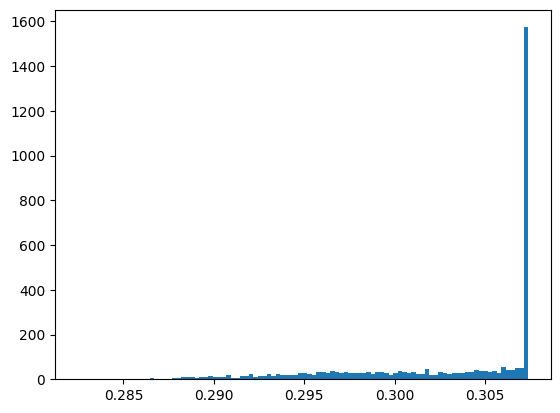

In [45]:
plt.hist(test_preds, bins=100)
plt.show()

# Submission

In [46]:
test_df = pd.read_parquet(osp.join(DATA_DIR, "df_test.parquet"))
submission_pred = best_model.predict_proba(test_df)[:, 1]
#submission_pred_bool = submission_pred>best_th
#submission_pred_int = [int(item) for item in submission_pred_bool]
submission = pd.DataFrame(data=dict(ID=test_df.index, Target=submission_pred))

In [47]:
submission.to_csv("submission_NN.csv", index=False)